 # Kiosk24

Late-night convenience stores, popularly known as Spaeti (German trivialization for late-night stores) have a cult status in Germany and have historically (together with Gas-stations) catered the needs for late-night groceries and other essential suppies when normal supermarkets are closed. Kiosk24 is Germany's largest all-day convenience store chain and is the leader in the country's 4 billion Euro late-night convinience store market. Their USP is that they are, unlike regular shops, open round-the-clock and 24/7.


### Problem statement

Kiosk24 started a pilot project in Berlin offering bicycle based delivery services. It has been gathering data over a period of one year and wants to get an estimated delivery time that it can provide the customers on the basis of a 10 variable strong feature-set that includes among others the distance from the store to their location, total on-duty delivery partners, no. of items ordered and total outstanding orders.

This dataset hence has the required data to train a regression model that will estimate the delivery-time (dependent variable)  based on the feature-set (independent variable).

## Feature Set

store_id: individual id of the store

created_at: the timestamp at which the order was placed

delivered_at: the timestamp when the order was delivered

total_items: total number of items

distinct_items: number of distinct items in the order

subtotal: final bill of the order

total_onshift_runners: no. of delivery partners on duty at order placement

total_busy_runners: number of delivery partners attending to other tasks

total_outstanding_orders: total number of orders to be fulfilled at the moment

store_to_consumer_driving_duration_seconds: approximate travel time from restaurant to customer

## ML Development Lifecycle

### Data preperation

***importing libraries***

In [39]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
#for reading and handling the data
import pandas as pd
import numpy as np
import os

#for visualizinng and analyzing data
import matplotlib.pyplot as plt
import seaborn as sns

#data preprocessing
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#random forest model training
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

#artificial neural network training
from sklearn import preprocessing
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsolutePercentageError
from tensorflow.keras.metrics import mean_absolute_percentage_error
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import load_model

#Modelbit model deployment
import modelbit
import joblib

In [3]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

***loading data***

In [4]:
for dirname, _, filenames in os.walk('C:\Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
df=pd.read_excel('Kiosk24_data.xlsx')

***understanding data as seen by programming environment***

In [6]:
df.head()

,store_id,created_at,delivered_at,total_items,distinct_items,subtotal,total_onshift_runners,total_busy_runners,total_outstanding_orders,store_to_consumer_driving_duration_seconds
0,1,2015-02-06 22:24:00,2015-02-06 23:11:00,4,4,39.10,33,14,21,861
1,2,2015-02-10 21:49:00,2015-02-10 22:33:00,1,1,21.59,1,2,2,690
2,2,2015-02-16 00:11:00,2015-02-16 01:06:00,4,3,54.22,8,6,18,289
3,1,2015-02-12 03:36:00,2015-02-12 04:35:00,1,1,17.33,5,6,8,795
4,1,2015-01-27 02:12:00,2015-01-27 02:58:00,2,2,41.14,5,5,7,205


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 10 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   store_id                                    175777 non-null  int64         
 1   created_at                                  175777 non-null  datetime64[ns]
 2   delivered_at                                175777 non-null  datetime64[ns]
 3   total_items                                 175777 non-null  int64         
 4   distinct_items                              175777 non-null  int64         
 5   subtotal                                    175777 non-null  float64       
 6   total_onshift_runners                       175777 non-null  int64         
 7   total_busy_runners                          175777 non-null  int64         
 8   total_outstanding_orders                    175777 non-null  int64        

### Feature engineering

***preparing the data for further analysis***

In [8]:
df['store_to_consumer_driving_duration_mins']=round(df['store_to_consumer_driving_duration_seconds']/60, 0)

In [9]:
df['time_to_delivery']=df['delivered_at'] - df['created_at']

In [10]:
df['time_to_delivery_mins']=df['time_to_delivery']/pd.Timedelta('60s')

In [11]:
df['created_at_hour']=df['created_at'].dt.hour
df['created_at_day']=df['created_at'].dt.dayofweek

In [12]:
# Define a dictionary to map numeric day of the week to day names
day_names = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

In [13]:
# Create a new column with day names based on the 'created_at_day' column
df['created_at_day_name'] = df['created_at_day'].map(day_names)

***cleaning data***

In [14]:
df.drop(['store_to_consumer_driving_duration_seconds','time_to_delivery','created_at','delivered_at'],axis=1,inplace=True)

In [15]:
df.isna().sum()

store_id                                   0
total_items                                0
distinct_items                             0
subtotal                                   0
total_onshift_runners                      0
total_busy_runners                         0
total_outstanding_orders                   0
store_to_consumer_driving_duration_mins    0
time_to_delivery_mins                      0
created_at_hour                            0
created_at_day                             0
created_at_day_name                        0
dtype: int64

In [16]:
df.dropna(inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 12 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   store_id                                 175777 non-null  int64  
 1   total_items                              175777 non-null  int64  
 2   distinct_items                           175777 non-null  int64  
 3   subtotal                                 175777 non-null  float64
 4   total_onshift_runners                    175777 non-null  int64  
 5   total_busy_runners                       175777 non-null  int64  
 6   total_outstanding_orders                 175777 non-null  int64  
 7   store_to_consumer_driving_duration_mins  175777 non-null  float64
 8   time_to_delivery_mins                    175777 non-null  float64
 9   created_at_hour                          175777 non-null  int64  
 10  created_at_day                  

In [18]:
df['store_id']=df['store_id'].astype('category').cat.codes

In [19]:
df['created_at_hour']=df['created_at_hour'].astype('category').cat.codes

In [20]:
df['created_at_day']=df['created_at_day'].astype('category').cat.codes

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 12 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   store_id                                 175777 non-null  int8   
 1   total_items                              175777 non-null  int64  
 2   distinct_items                           175777 non-null  int64  
 3   subtotal                                 175777 non-null  float64
 4   total_onshift_runners                    175777 non-null  int64  
 5   total_busy_runners                       175777 non-null  int64  
 6   total_outstanding_orders                 175777 non-null  int64  
 7   store_to_consumer_driving_duration_mins  175777 non-null  float64
 8   time_to_delivery_mins                    175777 non-null  float64
 9   created_at_hour                          175777 non-null  int8   
 10  created_at_day                  

In [22]:
df.head()

,store_id,total_items,distinct_items,subtotal,total_onshift_runners,total_busy_runners,total_outstanding_orders,store_to_consumer_driving_duration_mins,time_to_delivery_mins,created_at_hour,created_at_day,created_at_day_name
0,0,4,4,39.10,33,14,21,14.0,47.0,17,4,Friday
1,1,1,1,21.59,1,2,2,12.0,44.0,16,1,Tuesday
2,1,4,3,54.22,8,6,18,5.0,55.0,0,0,Monday
3,0,1,1,17.33,5,6,8,13.0,59.0,3,3,Thursday
4,0,2,2,41.14,5,5,7,3.0,46.0,2,1,Tuesday


In [23]:
#df.to_excel("Kiosk24_data_mod.xlsx", index=False)

***visualizing data***

<Axes: >

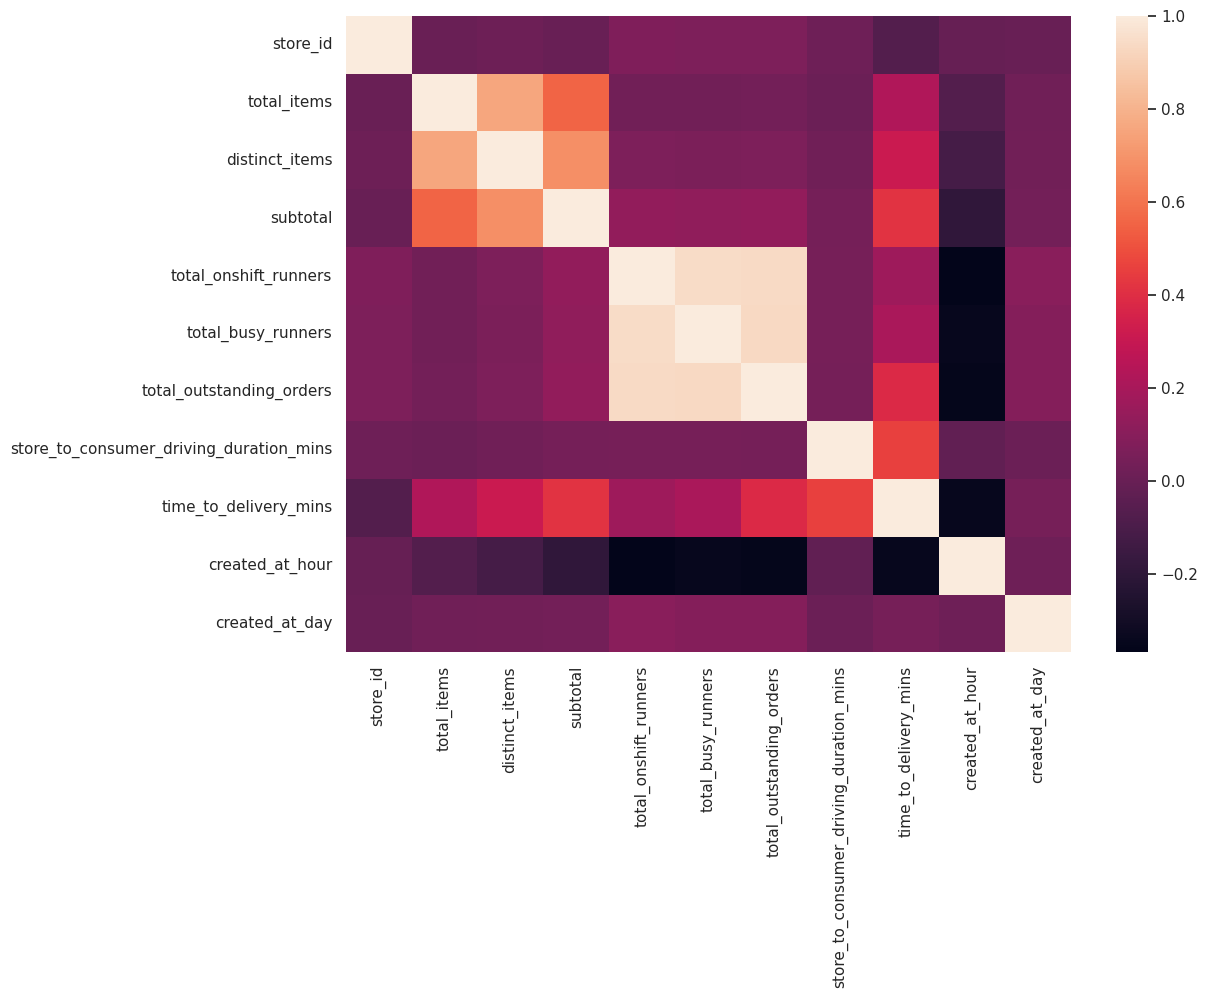

In [24]:
sns.heatmap(df[[col for col in df.columns if col != 'created_at_day_name']].corr())

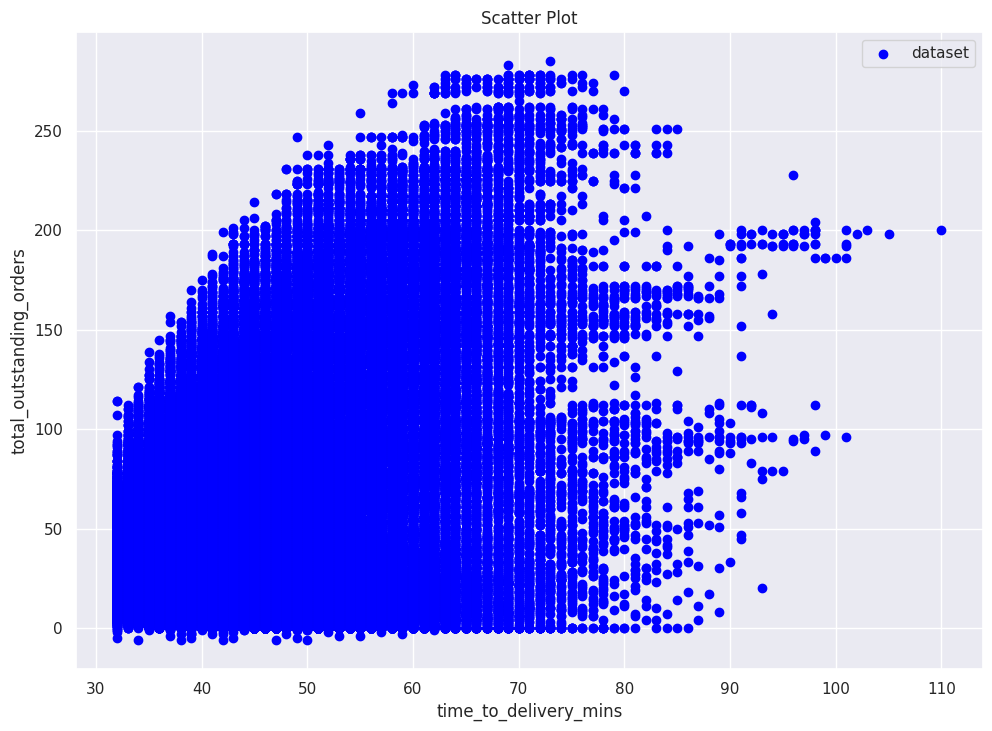

In [25]:
plt.scatter(df.time_to_delivery_mins, df.total_outstanding_orders, label='dataset', color='blue')

plt.xlabel('time_to_delivery_mins')
plt.ylabel('total_outstanding_orders')
plt.title('Scatter Plot')

# Add a legend to distinguish the two DataFrames
plt.legend()

<Axes: xlabel='total_items', ylabel='subtotal'>

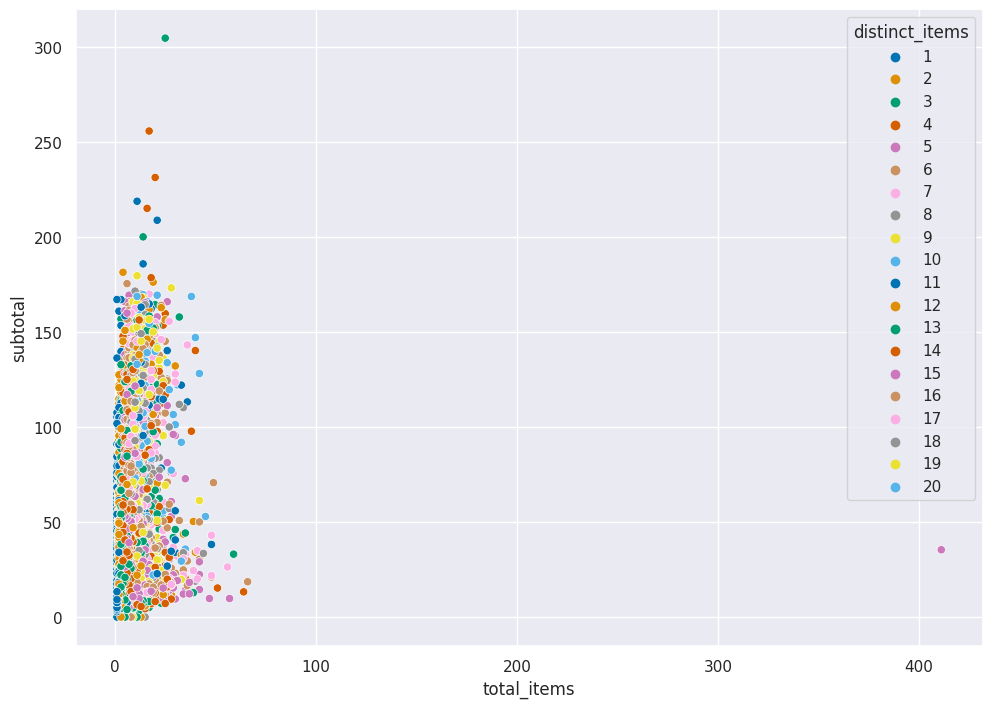

In [26]:
sns.scatterplot(x='total_items',y='subtotal',hue='distinct_items',palette='colorblind',data=df)

***identifying outliers***

In [27]:
model1=LocalOutlierFactor()
#model1.fit(df)
df['lof_anomaly_score']=model1.fit_predict(df[[col for col in df.columns if col != 'created_at_day_name']])

In [28]:
print("number of outliers : ",(len(df.loc[(df['lof_anomaly_score'] == -1)])))
df_anomaly=df.loc[(df['lof_anomaly_score'] == -1)]
df=df.loc[(df['lof_anomaly_score'] == 1)]

number of outliers :  801


In [29]:
df.drop(['lof_anomaly_score'],axis=1,inplace=True)

<ipython-input-29-a629ff9cb1da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['lof_anomaly_score'],axis=1,inplace=True)


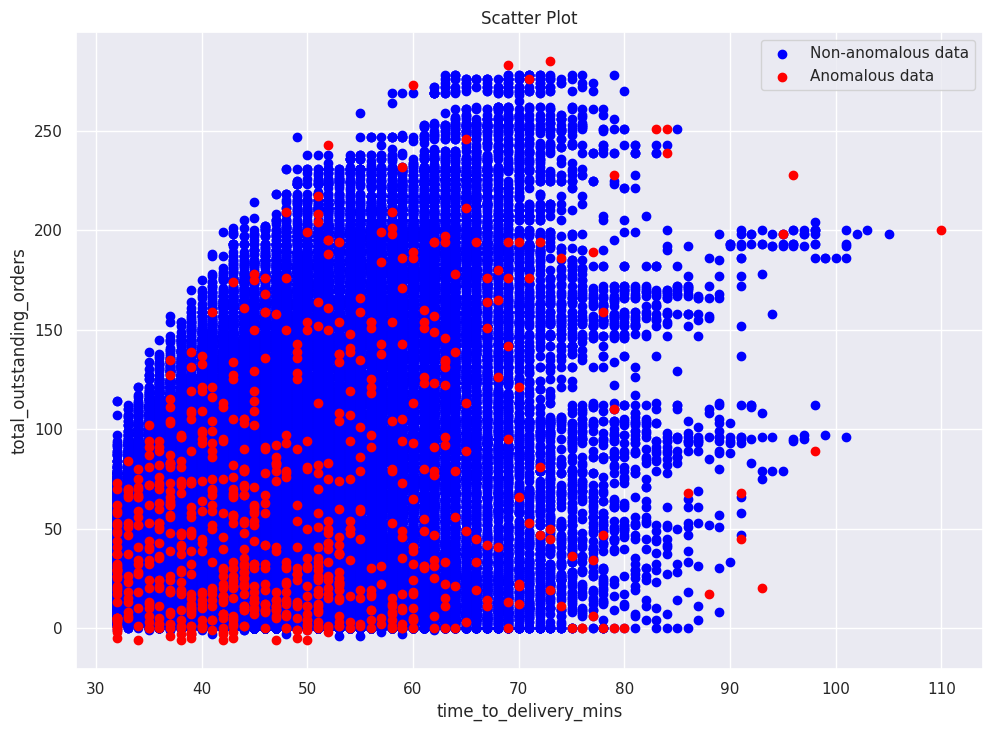

In [30]:
plt.scatter(df.time_to_delivery_mins, df.total_outstanding_orders, label='Non-anomalous data', color='blue')
plt.scatter(df_anomaly.time_to_delivery_mins, df_anomaly.total_outstanding_orders, label='Anomalous data', color='red')

plt.xlabel('time_to_delivery_mins')
plt.ylabel('total_outstanding_orders')
plt.title('Scatter Plot')

# Add a legend to distinguish the two DataFrames
plt.legend()

<Axes: xlabel='time_to_delivery_mins', ylabel='total_outstanding_orders'>

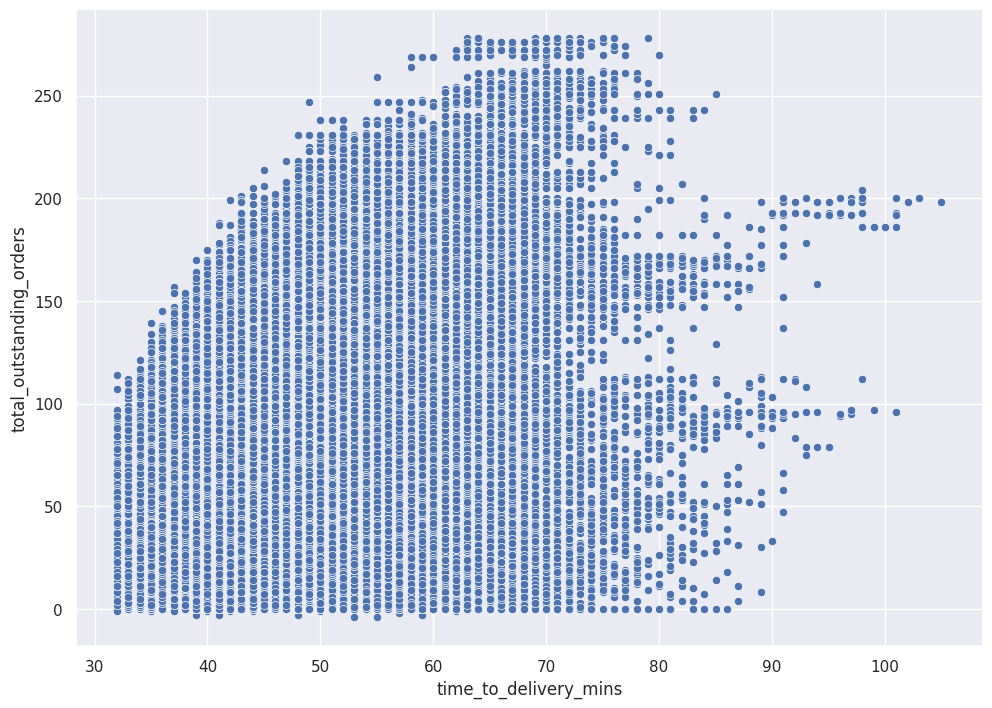

In [31]:
sns.scatterplot(x='time_to_delivery_mins',y='total_outstanding_orders',data=df)

***analyzing data***

<Axes: xlabel='created_at_day', ylabel='count'>

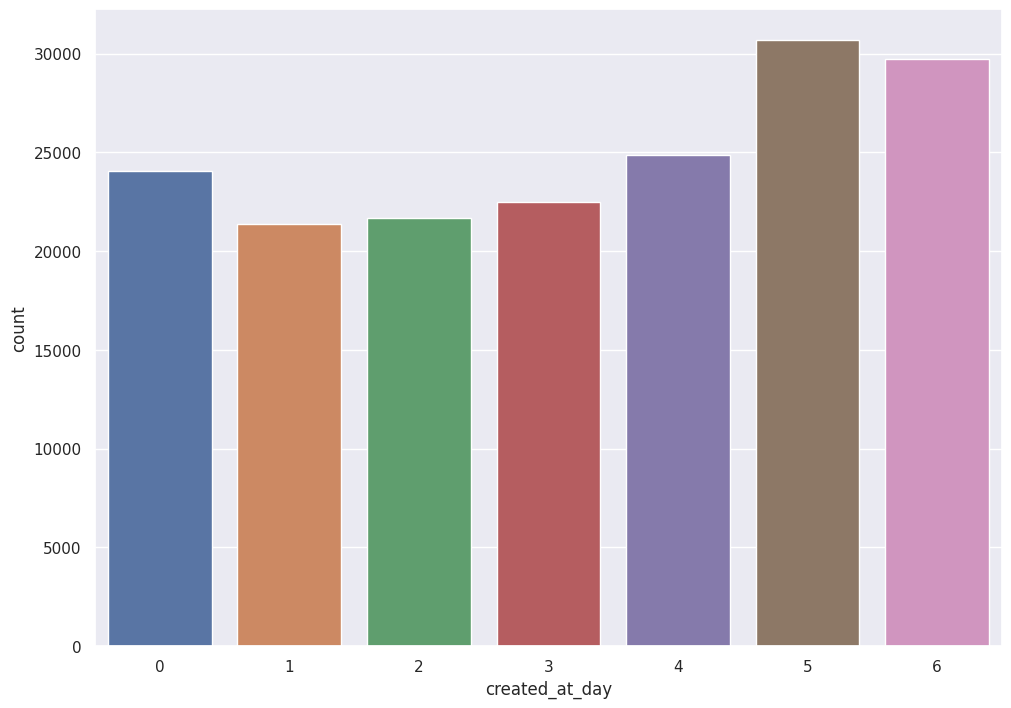

In [32]:
sns.countplot(x=df.created_at_day)

In [33]:
# Specify the order of the x-axis categories
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

<Axes: xlabel='created_at_day_name', ylabel='count'>

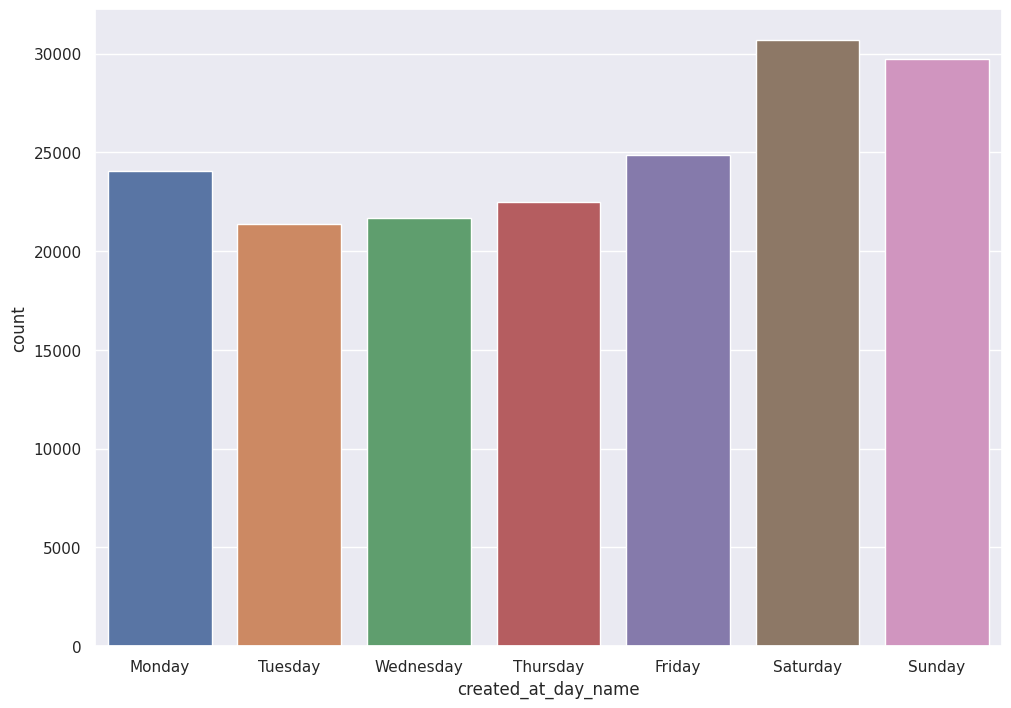

In [34]:
sns.countplot(x=df.created_at_day_name, order=order)

<Axes: xlabel='created_at_hour', ylabel='count'>

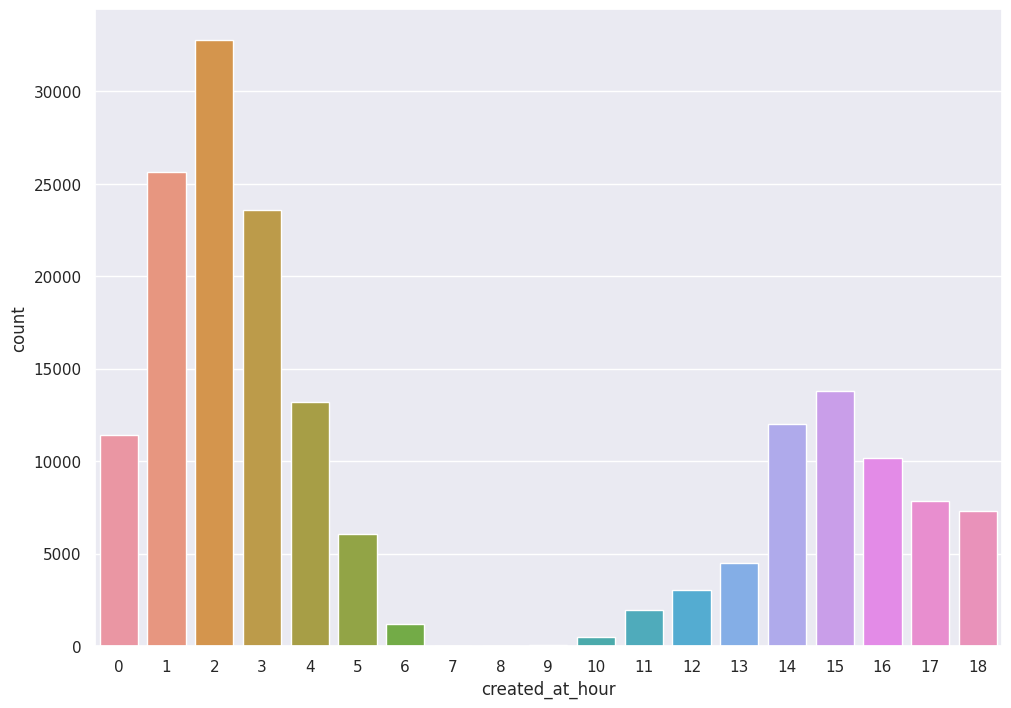

In [35]:
sns.countplot(x=df.created_at_hour)

### Data Splitting and Modelling

***storing independent and dependent variables seperately***

In [36]:
y=df['time_to_delivery_mins']
x=df.drop(['time_to_delivery_mins', 'created_at_day_name'],axis=1)


In [37]:
X_train_RF,X_test_RF,y_train_RF,y_test_RF=train_test_split(x,y,test_size=0.2,random_state=42)

In [38]:
x.head()

,store_id,total_items,distinct_items,subtotal,total_onshift_runners,total_busy_runners,total_outstanding_orders,store_to_consumer_driving_duration_mins,created_at_hour,created_at_day
0,0,4,4,39.10,33,14,21,14.0,17,4
1,1,1,1,21.59,1,2,2,12.0,16,1
2,1,4,3,54.22,8,6,18,5.0,0,0
3,0,1,1,17.33,5,6,8,13.0,3,3
4,0,2,2,41.14,5,5,7,3.0,2,1


In [40]:
y.head()

0    47.0
1    44.0
2    55.0
3    59.0
4    46.0
Name: time_to_delivery_mins, dtype: float64

#### Supervised Learning - Random Forest Regression Model

***initializing the RF model***

In [130]:
RF_regressor=RandomForestRegressor()
RF_regressor.fit(X_train_RF,y_train_RF)

RandomForestRegressor()

***training the RF model***

In [ ]:
prediction=RF_regressor.predict(X_test_RF)

***calculating performance metrics***

In [131]:
mse=mean_squared_error(y_test_RF,prediction)
rmse=mse**.5
print("mse : ",mse)
print("rmse : ",rmse)
mae=mean_absolute_error(y_test_RF,prediction)
print("mase : ",mae)

mse :  3.9588216395423164
rmse :  1.9896787779795804
mase :  1.4754132581138526


In [132]:
r2_score(y_test_RF,prediction)

0.954812729345795

In [133]:
def MAPE(Y_actual,Y_Predicted):
    mape=np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [134]:
print("mape : ",MAPE(y_test_RF,prediction))

mape :  3.232319290341489


***plotting feature-importance metrics***

Text(0.5, 0, 'Random Forest Feature Importance')

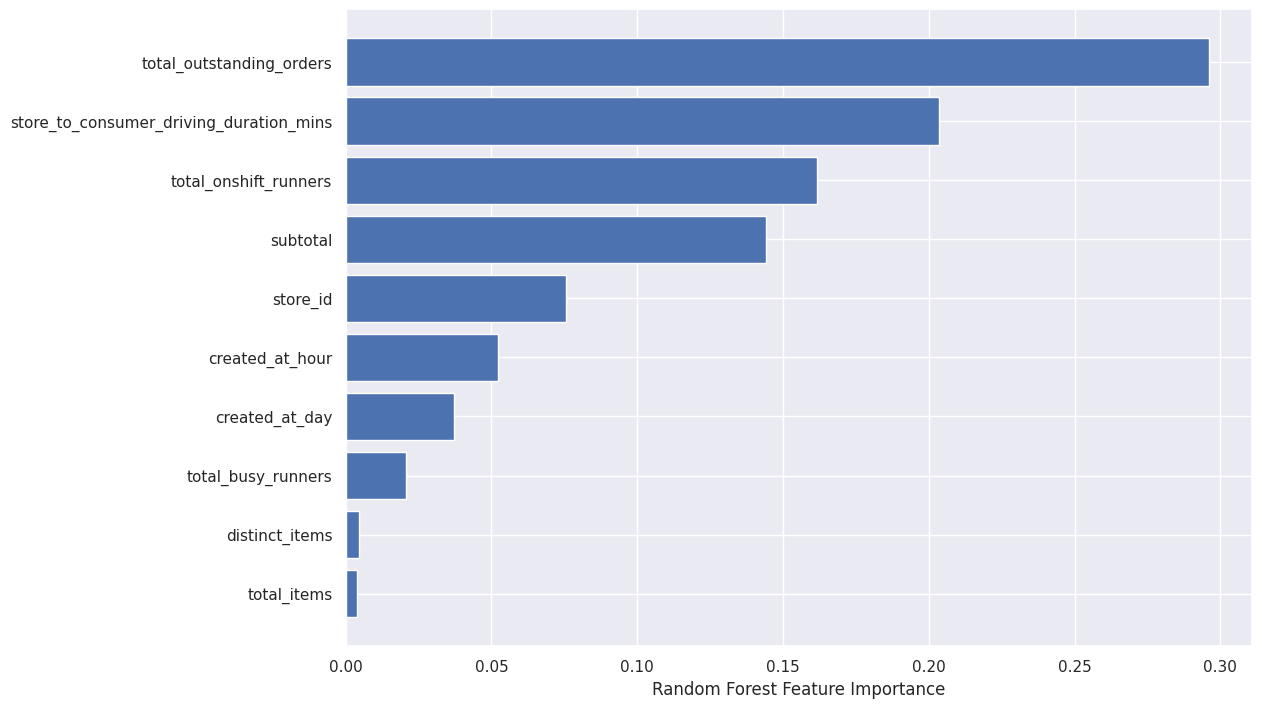

In [135]:
sorted_idx=RF_regressor.feature_importances_.argsort()
plt.barh(x.columns[sorted_idx],RF_regressor.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

#### Supervised Learning - Neural Networks

***scaling data before feeding to ANN***

In [41]:
scaler=preprocessing.MinMaxScaler()
x_scaled=scaler.fit_transform(x)
X_train_ANN_scaled,X_test_ANN_scaled,y_train_ANN_scaled,y_test_ANN_scaled=train_test_split(x_scaled,y,test_size=0.2,random_state=42)

***configuring the ANN***

In [42]:
ANN_model=Sequential()
ANN_model.add(Dense(14,kernel_initializer='normal',activation='relu'))
ANN_model.add(Dense(512,activation='relu'))
ANN_model.add(Dense(1024,activation='relu'))
ANN_model.add(Dense(256,activation='relu'))
ANN_model.add(Dense(1,activation='linear'))

***training the ANN***

In [43]:
adam=Adam(learning_rate=0.01)
ANN_model.compile(loss='mse',optimizer=adam,metrics=['mse','mae'])
history=ANN_model.fit(X_train_ANN_scaled,y_train_ANN_scaled,epochs=30,batch_size=512,verbose=1,validation_split=0.2)

Epoch 1/30
219/219 [==============================] - 12s 46ms/step - loss: 217.6809 - mse: 217.6809 - mae: 9.1983 - val_loss: 9.1728 - val_mse: 9.1728 - val_mae: 2.2848
Epoch 2/30
219/219 [==============================] - 10s 47ms/step - loss: 6.0582 - mse: 6.0582 - mae: 1.8801 - val_loss: 4.0873 - val_mse: 4.0873 - val_mae: 1.5245
Epoch 3/30
219/219 [==============================] - 12s 55ms/step - loss: 4.1660 - mse: 4.1660 - mae: 1.5482 - val_loss: 3.6192 - val_mse: 3.6192 - val_mae: 1.4625
Epoch 4/30
219/219 [==============================] - 10s 47ms/step - loss: 3.7729 - mse: 3.7729 - mae: 1.4748 - val_loss: 3.3114 - val_mse: 3.3114 - val_mae: 1.3744
Epoch 5/30
219/219 [==============================] - 10s 47ms/step - loss: 3.6301 - mse: 3.6301 - mae: 1.4593 - val_loss: 3.3004 - val_mse: 3.3004 - val_mae: 1.3679
Epoch 6/30
219/219 [==============================] - 10s 44ms/step - loss: 3.3700 - mse: 3.3700 - mae: 1.4197 - val_loss: 3.0133 - val_mse: 3.0133 - val_mae: 1.3752


***plotting the training history***

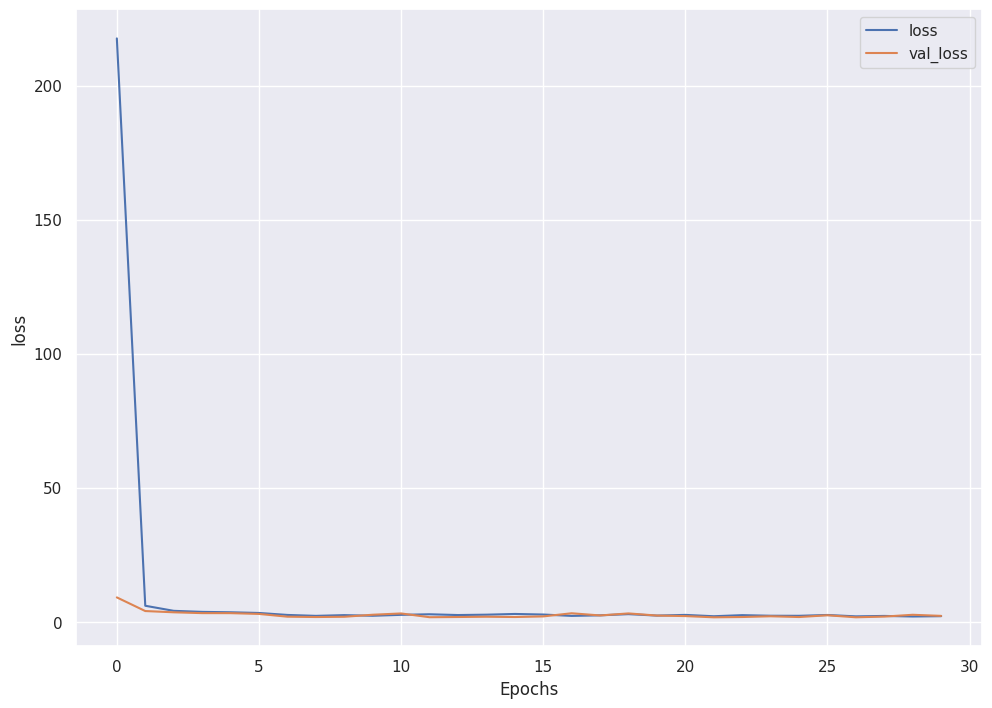

In [49]:
def plot_history(history,key):
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key,'val_'+key])
    plt.show()
#plot the history
plot_history(history,'loss')

***calculating performance metrics***

In [140]:
z_scaled = ANN_model.predict(X_test_ANN_scaled)

1094/1094 [==============================] - 6s 5ms/step


In [141]:
r2_score(y_test_ANN_scaled, z_scaled)

0.9812296597378213

In [148]:
mse = mean_squared_error(y_test_ANN, z)
rmse = mse**.5
print("mse : ",mse)
print("rmse : ",rmse)
print("errors for neural net")
mae = mean_absolute_error(y_test_ANN, z)
print("mae : ",mae)

mse :  1.8401040600747824
rmse :  1.356504353135213
errors for neural net
mae :  1.0484327619750782


In [149]:
mean_absolute_percentage_error(y_test_ANN, z)

0.023490778239000434

***scaling data before feeding to neural network and creating a custom TensorFlow layer that performs the scaling operation (alernate method)***

In [142]:
# X_train_ANN,X_test_ANN,y_train_ANN,y_test_ANN=train_test_split(x,y,test_size=0.2,random_state=42)

In [143]:
# import tensorflow as tf
# from sklearn import preprocessing

# class MinMaxScalerLayer(tf.keras.layers.Layer):
#     def __init__(self, scaler_s, **kwargs):
#         super(MinMaxScalerLayer, self).__init__(**kwargs)
#         self.min_ = tf.Variable(initial_value=scaler_s.data_min_, trainable=False, dtype=tf.float32)
#         self.scale_ = tf.Variable(initial_value=scaler_s.scale_, trainable=False, dtype=tf.float32)

#     def call(self, inputs):
#         return (inputs - self.min_) * self.scale_


In [144]:
# # Train-test split without scaling
# X_train_ANN, X_test_ANN, y_train_ANN, y_test_ANN = train_test_split(x, y, test_size=0.2, random_state=42)

# # Initialize the MinMaxScaler and fit on the training data
# scaler_scaled = preprocessing.MinMaxScaler()
# scaler_scaled.fit(X_train_ANN)

# # Create a new sequential model
# ANN_model_scaled = tf.keras.Sequential()

# # Add the scaler layer to the model
# ANN_model_scaled.add(MinMaxScalerLayer(scaler_scaled, input_shape=(X_train_ANN.shape[1],)))

# # Rest of your model architecture
# ANN_model_scaled.add(Dense(14, kernel_initializer='normal', activation='relu'))
# ANN_model_scaled.add(Dense(512, activation='relu'))
# ANN_model_scaled.add(Dense(1024, activation='relu'))
# ANN_model_scaled.add(Dense(256, activation='relu'))
# ANN_model_scaled.add(Dense(1, activation='linear'))

# # Compile and train the model
# adam = Adam(learning_rate=0.01)
# ANN_model_scaled.compile(loss='mse', optimizer=adam, metrics=['mse', 'mae'])
# history = ANN_model_scaled.fit(X_train_ANN, y_train_ANN, epochs=30, batch_size=512, verbose=1, validation_split=0.2)

Epoch 1/30
219/219 [==============================] - 19s 82ms/step - loss: 77.3646 - mse: 77.3646 - mae: 5.0478 - val_loss: 6.1211 - val_mse: 6.1211 - val_mae: 1.9568
Epoch 2/30
219/219 [==============================] - 17s 79ms/step - loss: 3.7414 - mse: 3.7414 - mae: 1.5002 - val_loss: 3.8366 - val_mse: 3.8366 - val_mae: 1.6054
Epoch 3/30
219/219 [==============================] - 18s 80ms/step - loss: 2.8101 - mse: 2.8101 - mae: 1.3280 - val_loss: 4.9620 - val_mse: 4.9620 - val_mae: 1.9026
Epoch 4/30
219/219 [==============================] - 17s 79ms/step - loss: 2.6207 - mse: 2.6207 - mae: 1.2849 - val_loss: 3.8538 - val_mse: 3.8538 - val_mae: 1.6082
Epoch 5/30
219/219 [==============================] - 18s 81ms/step - loss: 2.7313 - mse: 2.7313 - mae: 1.3157 - val_loss: 2.6951 - val_mse: 2.6951 - val_mae: 1.3363
Epoch 6/30
219/219 [==============================] - 18s 82ms/step - loss: 2.7227 - mse: 2.7227 - mae: 1.3083 - val_loss: 2.0646 - val_mse: 2.0646 - val_mae: 1.1295
Ep

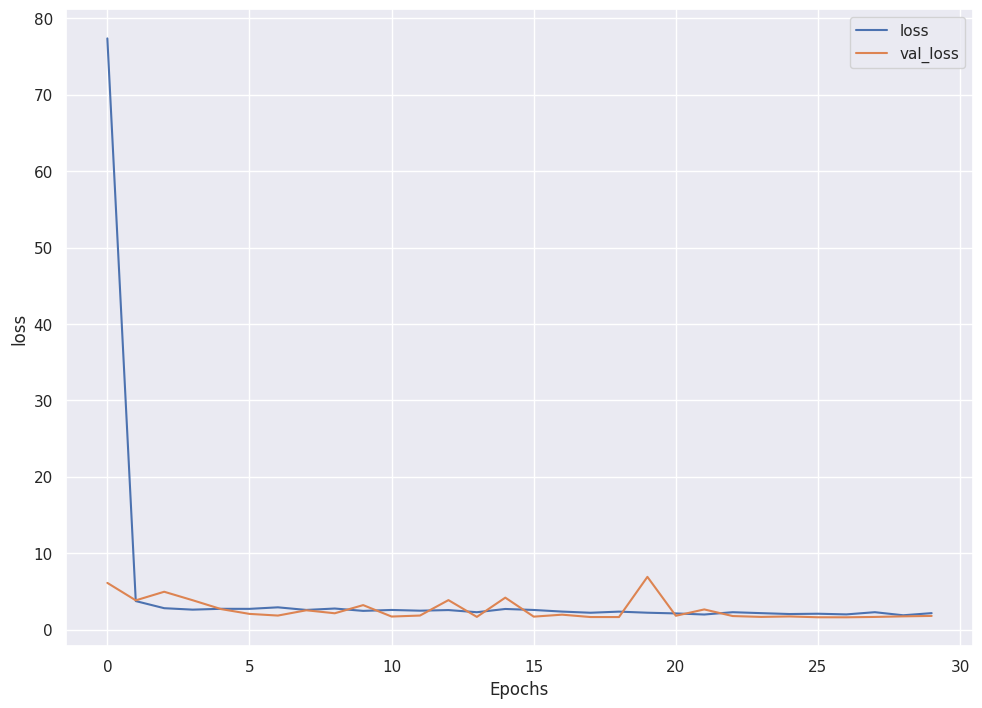

In [145]:
# def plot_history(history,key):
#     plt.plot(history.history[key])
#     plt.plot(history.history['val_'+key])
#     plt.xlabel("Epochs")
#     plt.ylabel(key)
#     plt.legend([key,'val_'+key])
#     plt.show()
# #plot the history
# plot_history(history,'loss')

In [146]:
# z=ANN_model_scaled.predict(X_test_ANN)

1094/1094 [==============================] - 5s 5ms/step


In [147]:
# r2_score(y_test_ANN, z)

0.9789964570861258

### Model Evaluation

***saving the model***

In [150]:
joblib.dump(RF_regressor, 'RF.joblib')

['RF.joblib']

In [45]:
joblib.dump(scaler, "scaler.joblib")

['scaler.joblib']

In [46]:
# Saving the model in SavedModel format
ANN_model.save("ANN")

In [155]:
# Saving the model in SavedModel format
# ANN_model_scaled.save("ANN_scaled")

***loading the model saved before***

In [217]:
# Load the model
RF_loaded_model = joblib.load("RF.joblib")

In [47]:
# Load the model from the SavedModel format
ANN_loaded_model = load_model("ANN")
# ANN_loaded_model_scaled = load_model("ANN_scaled")
#options = LoadOptions(experimental_io_device="/job:localhost")
#ANN_loaded_model = tf.keras.models.load_model("ANN", options=options)

# Load the MinMaxScaler using joblib
loaded_scaler = joblib.load("scaler.joblib")

***testing the model***

In [48]:
ANN_loaded_model.predict(loaded_scaler.transform(x.iloc[0:1])).flatten()

1/1 [==============================] - 0s 71ms/step


array([45.296677], dtype=float32)

In [159]:
# ANN_loaded_model_scaled.predict(x.iloc[0:1]).flatten()

1/1 [==============================] - 0s 123ms/step


array([46.29598], dtype=float32)

***defining predictor functions***

In [230]:
def RF_regressor_predictor(sample):
    
    """
    Predict the target value for a single sample using a regression model.
    """

    # Extract and return the predicted value
    return RF_loaded_model.predict(sample)

In [206]:
def RF_regressor_predictor_2(sample):
   
    """
    Predict the target value for a single sample using a regression model.
    """

    # Extract and return the predicted value
    return RF_regressor.predict(sample)

In [105]:
def ANN_regressor_predictor(sample):
    
    """
    Predict the target value for a single sample using a regression model.
    """

    # Extract and return the predicted value
    return ANN_loaded_model.predict(loaded_scaler.transform(sample)).flatten()

In [104]:
def ANN_regressor_predictor_2(sample):
    
    """
    Predict the target value for a single sample using a regression model.
    """

    # Extract and return the predicted value
    return ANN_model.predict(loaded_scaler.transform(sample)).flatten() 

In [163]:
def ANN_regressor_predictor_scaled(sample):
   
    """
    Predict the target value for a single sample using a regression model.
    """
    
    # Extract and return the predicted value
    return ANN_loaded_model_scaled.predict(sample).flatten()  

***testing the predictor functions***

In [52]:
example_input = x.iloc[0:1]

In [220]:
RF_regressor_predictor(example_input)

array([46.39])

In [208]:
RF_regressor_predictor_2(example_input)

array([46.39])

In [106]:
ANN_regressor_predictor(example_input)

1/1 [==============================] - 0s 17ms/step


array([45.296677], dtype=float32)

In [107]:
ANN_regressor_predictor_2(example_input)

1/1 [==============================] - 0s 20ms/step


array([45.296677], dtype=float32)

In [169]:
ANN_regressor_predictor_scaled(example_input)

1/1 [==============================] - 0s 34ms/step


array([46.29598], dtype=float32)

### Model deployment

***deploying API***

In [62]:
mb = modelbit.login()

In [231]:
mb.deploy(RF_regressor_predictor,
          dataframe_mode=True,
          example_dataframe=example_input, extra_files = "RF.joblib", python_packages=["scikit-learn==1.2.2"])

In [ ]:
mb.deploy(RF_regressor_predictor_2,
          dataframe_mode=True,
          example_dataframe=example_input, python_packages=["scikit-learn==1.2.2"])

In [108]:
mb.deploy(ANN_regressor_predictor,
          dataframe_mode=True,
          example_dataframe=example_input, python_packages=["tensorflow==2.14.0"])

Uploading 'ANN_loaded_model': 100%|██████████| 2.93M/2.93M [00:00<00:00, 4.05MB/s]


In [109]:
mb.deploy(ANN_regressor_predictor_2,
          dataframe_mode=True,
          example_dataframe=example_input, python_packages=["tensorflow==2.14.0", "numpy==1.23.5"])

Uploading 'ANN_model': 100%|██████████| 7.79M/7.79M [00:00<00:00, 9.31MB/s]


***testing the API***

In [232]:
# API on modelbit
import requests, json

requests.post(
    "https://vishwarathtomar.app.modelbit.com/v1/RF_regressor_predictor/latest",
    headers={"Content-Type":"application/json"},
    data=json.dumps({"data": {
        "store_id": 0,
        "total_items": 4,
        "distinct_items": 4,
        "subtotal": 39.1,
        "total_onshift_runners": 33,
        "total_busy_runners": 14,
        "total_outstanding_orders":21,
        "store_to_consumer_driving_duration_mins": 14,
        "created_at_hour": 17,
        "created_at_day": 4
    }})).json()

{'data': 46.39}

In [216]:
# API on modelbit
import requests, json

requests.post(
    "https://vishwarathtomar.app.modelbit.com/v1/RF_regressor_predictor_2/latest",
    headers={"Content-Type":"application/json"},
    data=json.dumps({"data": {
        "store_id": 0,
        "total_items": 4,
        "distinct_items": 4,
        "subtotal": 39.1,
        "total_onshift_runners": 33,
        "total_busy_runners": 14,
        "total_outstanding_orders":21,
        "store_to_consumer_driving_duration_mins": 14,
        "created_at_hour": 17,
        "created_at_day": 4
    }})).json()

{'data': 46.39}

In [111]:
# API on modelbit
import requests, json

requests.post(
    "https://vishwarathtomar.app.modelbit.com/v1/ANN_regressor_predictor/latest",
    headers={"Content-Type":"application/json"},
    data=json.dumps({"data": {
        "store_id": 0,
        "total_items": 4,
        "distinct_items": 4,
        "subtotal": 39.1,
        "total_onshift_runners": 33,
        "total_busy_runners": 14,
        "total_outstanding_orders":21,
        "store_to_consumer_driving_duration_mins": 14,
        "created_at_hour": 17,
        "created_at_day": 4
    }})).json()

{'data': 45.29667663574219}

In [110]:
# API on modelbit
import requests, json

requests.post(
    "https://vishwarathtomar.app.modelbit.com/v1/ANN_regressor_predictor_2/latest",
    headers={"Content-Type":"application/json"},
    data=json.dumps({"data": {
        "store_id": 0,
        "total_items": 4,
        "distinct_items": 4,
        "subtotal": 39.1,
        "total_onshift_runners": 33,
        "total_busy_runners": 14,
        "total_outstanding_orders":21,
        "store_to_consumer_driving_duration_mins": 14,
        "created_at_hour": 17,
        "created_at_day": 4
    }})).json()

{'data': 45.29667663574219}

In [ ]:
# API on local host
import requests, json

requests.post(
    "http://localhost:8605/v1/models/my_model:predict",
    headers={"Content-Type":"application/json"},
    data=json.dumps({"data": {
        "store_id": 0,
        "total_items": 4,
        "distinct_items": 4,
        "subtotal": 39.1,
        "total_onshift_runners": 33,
        "total_busy_runners": 14,
        "total_outstanding_orders":21,
        "store_to_consumer_driving_duration_mins": 14,
        "created_at_hour": 17,
        "created_at_day": 4
    }})).json()